# Course 2: Sentiment Analysis using Logistic Regression
In this project, I will build a sentiment analysis model using Logistic Regression:

* Learn how to extract features for logistic regression given some text
* Implement logistic regression using only mathematical formula without using any python library
* Apply logistic regression on a natural language processing task
* Validate your inference performance

## Table of Contents

- [Import Libraries and Data](#0)
- [1 - Extracting the Features](#1)
- [2 - Logistic Regression](#1)
    - [2.1 - Sigmoid function](#1-1)
    - [2.2 - Cost function and Gradient](#1-2)
- [3 - Training Your Model](#3)
- [4 - Test your Logistic Regression](#4)
    - [4.1 - Check the Performance using the Test Set](#4-1)
- [5 - Predict with your own text](#5)

<a name='0'></a>
## Import Libraries and Data

In [1]:

#import nltk
import nltk
from os import getcwd
import numpy as np
import pandas as pd
nltk.download()
nltk.download('stopwords')


print("Downloads completed!")


NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q
Downloads completed!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
df = pd.read_csv('/content/IMDB.csv')
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Prepare the Data

* Train set 80% and test set 20%.

In [3]:
from sklearn.model_selection import train_test_split

# Encode labels: pos=1, neg=0
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Shuffle data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split data
train_x, test_x, train_y, test_y = train_test_split(
    df['review'], df['label'], test_size=0.2, random_state=42
)

# Convert to NumPy arrays
train_x = np.array(train_x.tolist())
test_x = np.array(test_x.tolist())
train_y = np.array(train_y).reshape(-1, 1)
test_y = np.array(test_y).reshape(-1, 1)

print("Train X shape:", train_x.shape)
print("Test X shape:", test_x.shape)


print("Train Y shape:", train_y.shape)
print("Test Y shape:", test_y.shape)


Train X shape: (39999,)
Test X shape: (10000,)
Train Y shape: (39999, 1)
Test Y shape: (10000, 1)


In [4]:
train_x

array(['I haven\'t seen this film since it came out in the mid 70s, but I do recall it as being a very realistic portrayal of the music business ( right up there with Paul Simons "One Trick Pony " ..another vastly underrated film IMO )<br /><br />Harvey Keitel does an excellent job as a producer caught between the music he believes in , and the commercial "tripe" the record company "suits" want him to work with.<br /><br />Since I spent my entire career in the music business as a composer /arranger /producer, I can really vouch for the verisimilitude this film possesses. <br /><br />If it should ever come out on DVD uncut, I\'d buy it!',
       "I recently rented this movie as part of a nostalgic phase I'm going through. I was born in 1980, and so film from mid-80s to mid-90s has quite an important place in my growing up.<br /><br />This particular movie was one of my favourites, and so I was thrilled when it became available in the UK. It hasn't become worse with time, it is still a g

In [5]:
train_y

array([[1],
       [1],
       [0],
       ...,
       [1],
       [1],
       [0]])

* Create the function for processing the string/text:
    - tokenization.
    - remove stop words.
    - apply stemming.  

In [6]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import nltk


nltk.download('stopwords')

# Preprocessing function
def process_text(text):
    """Clean and preprocess IMDB review text."""

    # Lowercase
    text = text.lower()

    # Remove hyperlinks
    text = re.sub(r'https?://\S+', '', text)

    # Remove HTML tags (like <br />)
    text = re.sub(r'<.*?>', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tokens = tokenizer.tokenize(text)

    # Remove stopwords and apply stemming
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    cleaned = [
        stemmer.stem(word)
        for word in tokens
        if word not in stop_words and word.isalpha()
    ]

    return cleaned


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
process_text(train_x[100])

['spoiler',
 'film',
 'noth',
 'could',
 'written',
 'could',
 'make',
 'wors',
 'dictionari',
 'definit',
 'pueril',
 'read',
 'sex',
 'live',
 'potato',
 'men',
 'unless',
 'like',
 'dog',
 'poo',
 'mucou',
 'case',
 'film',
 'see',
 'johnni',
 'vega',
 'et',
 'think']

In [8]:
train_x_clean = [' '.join(process_text(text)) for text in train_x]
test_x_clean = [' '.join(process_text(text)) for text in test_x]


* Create the frequency dictionary function.  

In [9]:
import numpy as np

def build_freqs(texts, labels):
    """
    Inputs:
        texts  - a list/array of review texts
        labels - a 2D numpy array of labels (0 or 1)
    Output:
        freqs  - dictionary of (word, label) → frequency
    """
    # Flatten labels to 1D list
    labels_list = np.squeeze(labels).tolist()

    freqs = {}

    # Loop through each (label, text) pair
    for y, text in zip(labels_list, texts):
        for word in process_text(text):
            pair = (word, y)
            freqs[pair] = freqs.get(pair, 0) + 1

    return freqs


In [10]:
# create frequency dictionary
freqs = build_freqs(train_x, train_y)

print("Type of freqs:", type(freqs))
print("Number of (word, label) pairs:", len(freqs))


Type of freqs: <class 'dict'>
Number of (word, label) pairs: 184828


### Process Text
The given function 'process_text' tokenizes the review into individual words, removes stop words and applies stemming.

In [11]:
# test the function below
print('Original IMDB review:\n', train_x[0])
print('\nProcessed version of the review:\n', process_text(train_x[0]))

Original IMDB review:
 I haven't seen this film since it came out in the mid 70s, but I do recall it as being a very realistic portrayal of the music business ( right up there with Paul Simons "One Trick Pony " ..another vastly underrated film IMO )<br /><br />Harvey Keitel does an excellent job as a producer caught between the music he believes in , and the commercial "tripe" the record company "suits" want him to work with.<br /><br />Since I spent my entire career in the music business as a composer /arranger /producer, I can really vouch for the verisimilitude this film possesses. <br /><br />If it should ever come out on DVD uncut, I'd buy it!

Processed version of the review:
 ['havent', 'seen', 'film', 'sinc', 'came', 'mid', 'recal', 'realist', 'portray', 'music', 'busi', 'right', 'paul', 'simon', 'one', 'trick', 'poni', 'anoth', 'vastli', 'underr', 'film', 'imo', 'harvey', 'keitel', 'excel', 'job', 'produc', 'caught', 'music', 'believ', 'commerci', 'tripe', 'record', 'compani',

<a name='1'></a>
## 1 - Logistic Regression

<a name='1-1'></a>
### 1.1 - Sigmoid
You will learn to use logistic regression for text classification.
* The sigmoid function is defined as:

$$ h(z) = \frac{1}{1+\exp^{-z}} \tag{1}$$

It maps the input 'z' to a value that ranges between 0 and 1, and so it can be treated as a probability.

<div style="width:image width px; font-size:100%; text-align:center;"><img src='./images/sigmoid_plot.jpg' alt="alternate text" width="width" height="height" style="width:300px;height:200px;" /> Figure 1 </div>

In [12]:
def sigmoid(z):
    '''
    Inputs:
        z: is the input (can be a scalar or an array)
    Outputs:
        h: the sigmoid of z
    '''
    # calculate the sigmoid of z
    h = 1/(1+np.exp(-z))

    return h

#### Logistic Regression: Regression and a Sigmoid

Logistic regression takes a regular linear regression, and applies a sigmoid to the output of the linear regression.

Regression:
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$
Note that the $\theta$ values are "weights". If you took the deep learning specialization, we referred to the weights with the 'w' vector.  In this course, we're using a different variable $\theta$ to refer to the weights.

Logistic regression
$$ h(z) = \frac{1}{1+\exp^{-z}}$$
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$
We will refer to 'z' as the 'logits'.

<a name='1-2'></a>
### 1.2 - Cost function and Gradient

The cost function used for logistic regression is the average of the log loss across all training examples:

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^m y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)}))\tag{5} $$
* $m$ is the number of training examples
* $y^{(i)}$ is the actual label of training example 'i'.
* $h(z^{(i)})$ is the model's prediction for the training example 'i'.

The loss function for a single training example is
$$ Loss = -1 \times \left( y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)})) \right)$$

* All the $h$ values are between 0 and 1, so the logs will be negative. That is the reason for the factor of -1 applied to the sum of the two loss terms.
* Note that when the model predicts 1 ($h(z(\theta)) = 1$) and the label 'y' is also 1, the loss for that training example is 0.
* Similarly, when the model predicts 0 ($h(z(\theta)) = 0$) and the actual label is also 0, the loss for that training example is 0.
* However, when the model prediction is close to 1 ($h(z(\theta)) = 0.9999$) and the label is 0, the second term of the log loss becomes a large negative number, which is then multiplied by the overall factor of -1 to convert it to a positive loss value. $-1 \times (1 - 0) \times log(1 - 0.9999) \approx 9.2$ The closer the model prediction gets to 1, the larger the loss.

In [13]:
# verify that when the model predicts close to 1, but the actual label is 0, the loss is a large positive value
-1 * (1 - 0) * np.log(1 - 0.9999) # loss is about 9.2

np.float64(9.210340371976294)

* Likewise, if the model predicts close to 0 ($h(z) = 0.0001$) but the actual label is 1, the first term in the loss function becomes a large number: $-1 \times log(0.0001) \approx 9.2$.  The closer the prediction is to zero, the larger the loss.

In [14]:
# verify that when the model predicts close to 0 but the actual label is 1, the loss is a large positive value
-1 * np.log(0.0001) # loss is about 9.2

np.float64(9.210340371976182)

#### Update the weights

To update your weight vector $\theta$, you will apply gradient descent to iteratively improve your model's predictions.  
The gradient of the cost function $J$ with respect to one of the weights $\theta_j$ is:

$$\nabla_{\theta_j}J(\theta) = \frac{1}{m} \sum_{i=1}^m(h^{(i)}-y^{(i)})x^{(i)}_j \tag{5}$$
* 'i' is the index across all 'm' training examples.
* 'j' is the index of the weight $\theta_j$, so $x^{(i)}_j$ is the feature associated with weight $\theta_j$

* To update the weight $\theta_j$, we adjust it by subtracting a fraction of the gradient determined by $\alpha$:
$$\theta_j = \theta_j - \alpha \times \nabla_{\theta_j}J(\theta) $$
* The learning rate $\alpha$ is a value that we choose to control how big a single update will be.


<a name='ex-2'></a>
### Exercise 2 - gradientDescent
Implement gradient descent function.
* The number of iterations 'num_iters" is the number of times that you'll use the entire training set.
* For each iteration, you'll calculate the cost function using all training examples (there are 'm' training examples), and for all features.
* Instead of updating a single weight $\theta_i$ at a time, we can update all the weights in the column vector:  
$$\mathbf{\theta} = \begin{pmatrix}
\theta_0
\\
\theta_1
\\
\theta_2
\\
\vdots
\\
\theta_n
\end{pmatrix}$$
* $\mathbf{\theta}$ has dimensions (n+1, 1), where 'n' is the number of features, and there is one more element for the bias term $\theta_0$ (note that the corresponding feature value $\mathbf{x_0}$ is 1).
* The 'logits', 'z', are calculated by multiplying the feature matrix 'x' with the weight vector 'theta'.  $z = \mathbf{x}\mathbf{\theta}$
    * $\mathbf{x}$ has dimensions (m, n+1)
    * $\mathbf{\theta}$: has dimensions (n+1, 1)
    * $\mathbf{z}$: has dimensions (m, 1)
* The prediction 'h', is calculated by applying the sigmoid to each element in 'z': $h(z) = sigmoid(z)$, and has dimensions (m,1).
* The cost function $J$ is calculated by taking the dot product of the vectors 'y' and 'log(h)'.  Since both 'y' and 'h' are column vectors (m,1), transpose the vector to the left, so that matrix multiplication of a row vector with column vector performs the dot product.
$$J = \frac{-1}{m} \times \left(\mathbf{y}^T \cdot log(\mathbf{h}) + \mathbf{(1-y)}^T \cdot log(\mathbf{1-h}) \right)$$
* The update of theta is also vectorized.  Because the dimensions of $\mathbf{x}$ are (m, n+1), and both $\mathbf{h}$ and $\mathbf{y}$ are (m, 1), we need to transpose the $\mathbf{x}$ and place it on the left in order to perform matrix multiplication, which then yields the (n+1, 1) answer we need:
$$\mathbf{\theta} = \mathbf{\theta} - \frac{\alpha}{m} \times \left( \mathbf{x}^T \cdot \left( \mathbf{h-y} \right) \right)$$

In [15]:
def gradientDescent(x, y, theta, alpha, num_iters):
    '''
    Inputs:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Outputs:
        J: the final cost
        theta: your final weight vector
    '''
    # get 'm', the number of rows in matrix x
    m = len(x)
    for i in range(0, num_iters):

        # get z, the dot product of x and theta
        z = np.dot(x,theta)

        # get the sigmoid of z
        h = sigmoid(z)

        # calculate the cost function
        J = -1/m*(np.dot(y.transpose(),np.log(h))+np.dot((1-y).transpose(),np.log(1-h)))

        # update the weights theta
        theta = theta -alpha/m*(np.dot(x.transpose(),(h-y)))
    J = float(J)
    return J, theta


In [16]:
# Check the function
# Construct a synthetic test case using numpy PRNG functions
np.random.seed(1)
# X input is 10 x 3 with ones for the bias terms
tmp_X = np.append(np.ones((10, 1)), np.random.rand(10, 2) * 2000, axis=1)
# Y Labels are 10 x 1
tmp_Y = (np.random.rand(10, 1) > 0.35).astype(float)

# Apply gradient descent
tmp_J, tmp_theta = gradientDescent(tmp_X, tmp_Y, np.zeros((3, 1)), 1e-8, 700)
print(f"The cost after training is {tmp_J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(tmp_theta)]}")

The cost after training is 0.67094970.
The resulting vector of weights is [np.float64(4.1e-07), np.float64(0.00035658), np.float64(7.309e-05)]


<ipython-input-15-87cfadf101d0>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


In [17]:
# Check the gradient descent function
np.random.seed(1)
# X input is 20 x 3 with ones for the bias terms
tmp_X = np.append(np.ones((20, 1)), np.random.rand(20, 2) * 2000, axis=1)
# Y Labels are 20 x 1
tmp_Y = (np.random.rand(20, 1) > 0.35).astype(float)

# Apply gradient descent
tmp_J, tmp_theta = gradientDescent(tmp_X, tmp_Y, np.zeros((3, 1)), 1e-8, 1000)
# you can check gradient descent performance with different number of iterations (300, 500, 700, 1000, 1200, 1500)
print(f"The cost after training is {tmp_J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(tmp_theta)]}")

The cost after training is 0.66111809.
The resulting vector of weights is [np.float64(-3.9e-07), np.float64(-0.0003557), np.float64(0.00039862)]


<ipython-input-15-87cfadf101d0>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


<a name='2'></a>
## 2 - Extracting the Features

* Given a list of reviews, extract the features and store them in a matrix.
    * The first feature is the number of positive words in a review.
    * The second feature is the number of negative words in a review.
* Then train your logistic regression classifier on these features.
* Test the classifier on a validation set.


In [18]:
def extract_features(review, freqs, process_textt=process_text):

    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_text(review)

    # 3 elements for [bias, positive, negative] counts
    x = np.zeros(3)

    # bias term is set to 1
    x[0] = 1

    # loop through each word in the list of words
    for word in word_l:

        # increment the word count for the positive label 1
        x[1] += freqs.get((word, 1),0)

        # increment the word count for the negative label 0
        x[2] += freqs.get((word, 0),0)

    x = x[None, :]  # adding batch dimension for further processing
    assert(x.shape == (1, 3))
    return x


In [19]:
# Check your function
tmp1 = extract_features(train_x[0], freqs)
print(tmp1)

[[1.00000e+00 2.21321e+05 1.98587e+05]]


In [20]:
# test 2:
# check for when the words are not in the freqs dictionary
tmp2 = extract_features('bfhuehv blfeej34b bloodecweb', freqs)
print(tmp2)

[[1. 0. 0.]]


<a name='3'></a>
## 3 - Training Your Model

To train the model:
* Stack the features for all training examples into a matrix X.
* Call `gradientDescent`, which you've implemented above.


In [21]:
# Collect the features from each IMDB review and stack into matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :] = extract_features(train_x[i], freqs)

# Training labels corresponding to X
Y = train_y

# Apply gradient descent to learn weights (theta)
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 6500)

# Print training cost and weights
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")




<ipython-input-15-87cfadf101d0>:24: RuntimeWarning: divide by zero encountered in log
  J = -1/m*(np.dot(y.transpose(),np.log(h))+np.dot((1-y).transpose(),np.log(1-h)))
<ipython-input-12-1e5aa93da050>:9: RuntimeWarning: overflow encountered in exp
  h = 1/(1+np.exp(-z))


The cost after training is nan.
The resulting vector of weights is [np.float64(2e-08), np.float64(0.00165088), np.float64(-0.00143872)]


<ipython-input-15-87cfadf101d0>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


<a name='4'></a>
## 4 -  Test your Logistic Regression

Finally we have to test logistic regression.
<a name='ex-4'></a>

Implement `predict_review`.
Predict whether a review is positive or negative.

* Given a review, process it, then extract the features.
* Apply the model's learned weights on the features to get the logits.
* Apply the sigmoid to the logits to get the prediction (a value between 0 and 1).

$$y_{pred} = sigmoid(\mathbf{x} \cdot \theta)$$

In [22]:
def predict_review(review, freqs, theta):
    '''
    Input:
        review: a string (IMDB review)
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output:
        y_pred: the probability of a review being positive or negative
    '''
    # extract the features of the review
    x = extract_features(review, freqs)

    # make the prediction using x and theta
    y_pred = sigmoid(np.dot(x, theta))

    return y_pred

In [23]:
# Test example reviews
for review in [
    "This film was brilliant and heartwarming.",
    "Absolutely terrible acting and a horrible plot."

]:
    prediction = predict_review(review, freqs, theta)[0][0]
    print(f"{review} -> {prediction:.6f}")


This film was brilliant and heartwarming. -> 1.000000
Absolutely terrible acting and a horrible plot. -> 0.000008


In [24]:
# Your own reviews
my_review = "I am learning to appreciate great cinema. This film was a work of art."
my_review_neg = "Horrible movie. The plot made no sense and the ending was frustrating."

print(f"{my_review} -> {predict_review(my_review, freqs, theta)[0][0]:.6f}")
print(f"{my_review_neg} -> {predict_review(my_review_neg, freqs, theta)[0][0]:.6f}")


I am learning to appreciate great cinema. This film was a work of art. -> 1.000000
Horrible movie. The plot made no sense and the ending was frustrating. -> 0.000006


In [25]:
# Test ambiguous (uncertain) IMDB-style reviews
ambiguous_reviews = [
    "The movie had some good moments, but overall it felt flat.",
    "I liked the idea, but the execution could have been better.",
    "Not the best film I've seen, but not the worst either.",
    "Some scenes were beautiful, but I couldn't connect with the story.",
    "It started strong, but the ending ruined it for me."
]

for review in ambiguous_reviews:
    prediction = predict_review(review, freqs, theta)[0][0]
    print(f"{review} -> {prediction:.6f}")


The movie had some good moments, but overall it felt flat. -> 0.023868
I liked the idea, but the execution could have been better. -> 0.001930
Not the best film I've seen, but not the worst either. -> 1.000000
Some scenes were beautiful, but I couldn't connect with the story. -> 0.999894
It started strong, but the ending ruined it for me. -> 0.769231


<a name='4-1'></a>
### 4.1 -  Check the Performance using the Test Set
After training your model using the training set above, we have to check the model accuracy

<a name='ex-5'></a>

Implement `test_logistic_regression`.
* Given the test data and the weights of your trained model, calculate the accuracy of your logistic regression model.
* Use your 'predict_tweet' function to make predictions on each tweet in the test set.
* If the prediction is > 0.5, set the model's classification 'y_hat' to 1, otherwise set the model's classification 'y_hat' to 0.
* A prediction is accurate when the y_hat equals the test_y.  Sum up all the instances when they are equal and divide by m.


In [26]:
def test_logistic_regression(reviews, labels, freqs, theta, predict_review=predict_review):
    """
    Input:
        reviews: a list of IMDB reviews (test set)
        labels: (m, 1) vector with the corresponding labels for the reviews
        freqs: a dictionary with the frequency of each (word, label) pair
        theta: weight vector of dimension (3, 1)
    Output:
        accuracy: (# of reviews classified correctly) / (total # of reviews)
    """
    # List to store predictions
    y_hat = []

    for review in reviews:
        # Get the prediction for the current review
        y_pred = predict_review(review, freqs, theta)

        # Apply threshold to convert probability to binary class
        if y_pred > 0.5:
            y_hat.append(1.0)
        else:
            y_hat.append(0.0)

    # Convert predictions to (m,1) array for comparison
    y_hat = np.array(y_hat)[:, np.newaxis]

    # Calculate accuracy
    accuracy = np.sum(y_hat == labels) / len(labels)

    return accuracy


# Evaluate model on IMDB test set
tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, theta)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")


def get_logreg_predictions(test_x, test_y, freqs, theta):
    y_pred = []
    for review in test_x:
        pred_prob = predict_review(review, freqs, theta)[0][0]
        y_pred.append(1 if pred_prob > 0.5 else 0)
    return np.array(y_pred), test_y.flatten()



Logistic regression model's accuracy = 0.6205


Later in this specialization, we will see how we can use deeplearning to improve the prediction performance.

<a name='5'></a>
## 5 - Predict with your own text

In [27]:

my_review = "I expected a great movie, but it was boring and full of clichés."

print(process_text(my_review))
y_hat = predict_review(my_review, freqs, theta)
print(y_hat)


if y_hat > 0.5:
    print('Positive sentiment')
else:
    print('Negative sentiment')


['expect', 'great', 'movi', 'bore', 'full', 'cliché']
[[0.62862272]]
Positive sentiment


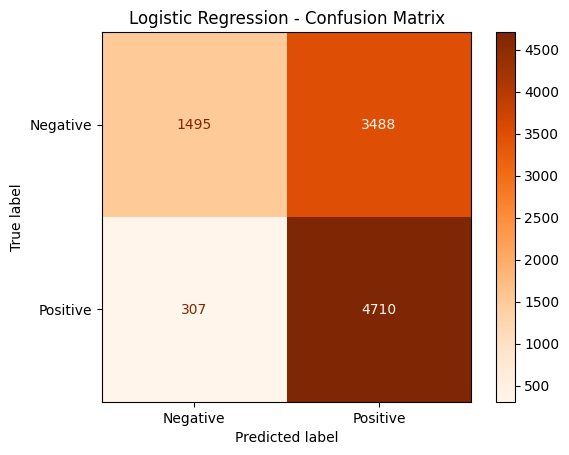

Logistic Regression - Classification Report
              precision    recall  f1-score   support

    Negative       0.83      0.30      0.44      4983
    Positive       0.57      0.94      0.71      5017

    accuracy                           0.62     10000
   macro avg       0.70      0.62      0.58     10000
weighted avg       0.70      0.62      0.58     10000



In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Get predictions and true labels for the test set

y_pred_lr, y_true_lr = get_logreg_predictions(test_x, test_y, freqs, theta)

# Confusion Matrix
cm = confusion_matrix(y_true_lr, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Oranges')
plt.title('Logistic Regression - Confusion Matrix')
plt.show()

# Classification Report
print("Logistic Regression - Classification Report")
print(classification_report(y_true_lr, y_pred_lr, target_names=['Negative', 'Positive']))

